#### Import important modules and declare important directories

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import json
import pandas as pd
import csv
import os
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline

filename = "cleaned_reviews_subset.json"

This is a function that we'll use later to plot the results of a linear SVM classifier

In [2]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()[0:200]
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    #create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

In [3]:
#This is the main folder where all the modules and JSON files are stored on my computer. 
#You need to change this to the folder path specific to your computer
file_directory = "/Users/ed/yelp-classification/"

#### Load in the sample JSON file and view its contents

In [4]:
#This is a smaller subset of our overall Yelp data 
#I randomly chose 5000 reviews from each state and filed them into the JSON file
#Note that for the overall dataset, we have about 2 million reviews. 
#That's why we need to use a data management system like MongoDB in order to hold all our data 
#and to more efficiently manipulate it

reviews_json = json.load(open(file_directory+filename))

In [5]:
#Let's see how reviews_json is set up
print(reviews_json.keys())

dict_keys(['OH', 'NC', 'WI', 'IL', 'AZ', 'NV'])


In [6]:
#We can see that on the highest level, the dictionary keys are the different states
#Let's look at the first entry under Ohio
print(reviews_json['OH'][0].keys())

dict_keys(['funny', 'user_id', 'review_id', 'text', 'business_id', 'state', 'stars', 'date', 'useful', 'type', 'cool'])


In [7]:
#So for each review filed under Ohio, we have many different attributes to choose from
#Let's look at what the review and rating was for the first review filed under Ohio
print(reviews_json['OH'][0]['text'])
print(reviews_json['OH'][0]['stars'])
print(reviews_json['OH'][0]['useful'])

Visited for the first time and was very impressed.  Tried the New Jack City burger and Lola Fries. The creamy avocado and chorizo were an incredible combination on the burger. I don't think I've ever had more delicious fries.  The ginger and rosemary made it hard to stop eating them. The kids meals were a good size and reasonably priced.  My husband got the Yo Burger and it came well done instead of medium as he'd ordered. They offered to make him a new one and the manager stuck around while he cut into it to make sure it was right. On top of that they only charged him for half his burger. I really want to try one of their shakes (with the added shot of liqueur ). They sound really good. The food is so yummy and filling who knows if I'll ever have room for dessert.  Kudos to Michael Simon.  

The weather was nice that day and they had the whole storefront was open. Made for a very pleasant lunchtime.
5
2


#### Now, let's create two lists for all the reviews in Ohio: 
* One that holds all the reviews 
* One that holds all the ratings

In [8]:
reviews = []
stars = []
useful = []

for key in reviews_json.keys():
    for review in reviews_json[key]:
        reviews.append(review['text'])
        stars.append(review['stars'])
        useful.append(review['useful'])
        
#Just for demonstration, let's pick out the same review example as above but from our respective lists
print(reviews[0])
print(stars[0])

Visited for the first time and was very impressed.  Tried the New Jack City burger and Lola Fries. The creamy avocado and chorizo were an incredible combination on the burger. I don't think I've ever had more delicious fries.  The ginger and rosemary made it hard to stop eating them. The kids meals were a good size and reasonably priced.  My husband got the Yo Burger and it came well done instead of medium as he'd ordered. They offered to make him a new one and the manager stuck around while he cut into it to make sure it was right. On top of that they only charged him for half his burger. I really want to try one of their shakes (with the added shot of liqueur ). They sound really good. The food is so yummy and filling who knows if I'll ever have room for dessert.  Kudos to Michael Simon.  

The weather was nice that day and they had the whole storefront was open. Made for a very pleasant lunchtime.
5


#### Let's plot the overall distribution of ratings aggregated across all of the states

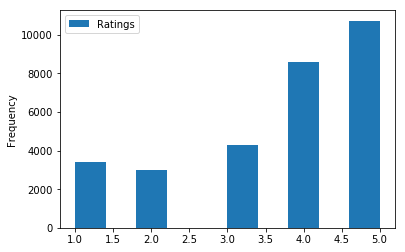

In [9]:
star_hist = pd.DataFrame({'Ratings':stars})
star_hist.plot.hist()

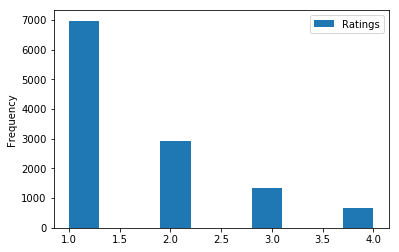

In [10]:
use_hist = pd.DataFrame({'Ratings':useful})
use_hist.plot.hist(range=[1, 4])

#### Let's plot the rating distribution of reviews within each of the states.

OH Rating Distribution


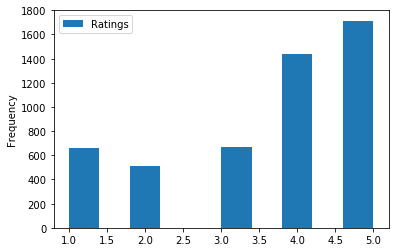

NC Rating Distribution


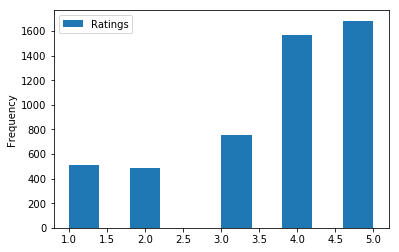

WI Rating Distribution


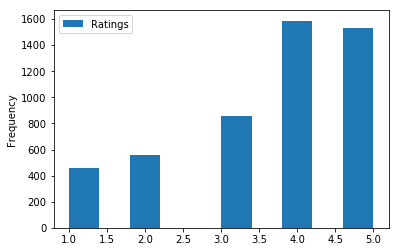

IL Rating Distribution


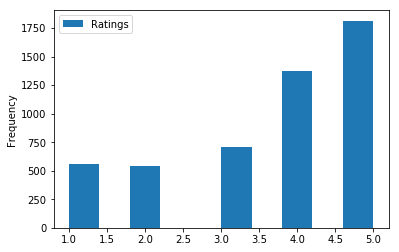

AZ Rating Distribution


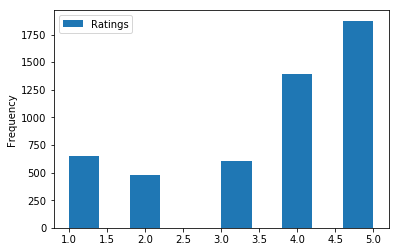

NV Rating Distribution


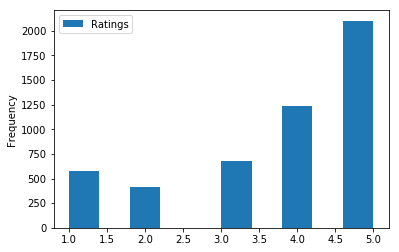

In [11]:
df_list = []
states = list(reviews_json.keys())
for state in states:
    stars_state = []
    for review in reviews_json[state]:
        stars_state.append(review['stars'])
    star_hist = pd.DataFrame({'Ratings':stars_state})
    df_list.append(star_hist)

for i in range(0, len(df_list)):
    print(states[i] + " Rating Distribution")
    df_list[i].plot.hist()
    plt.show()

OH Rating Distribution


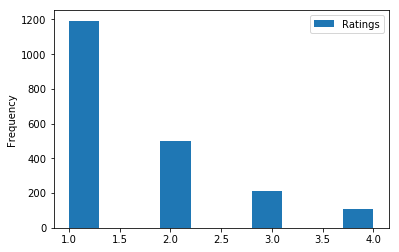

NC Rating Distribution


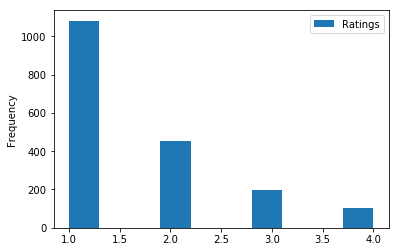

WI Rating Distribution


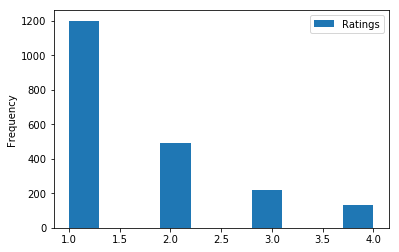

IL Rating Distribution


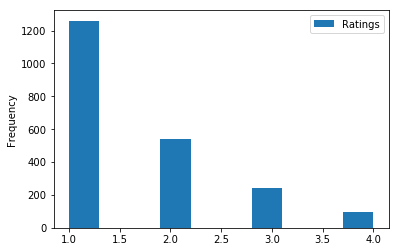

AZ Rating Distribution


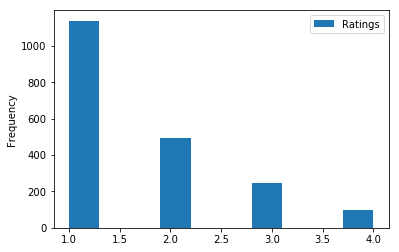

NV Rating Distribution


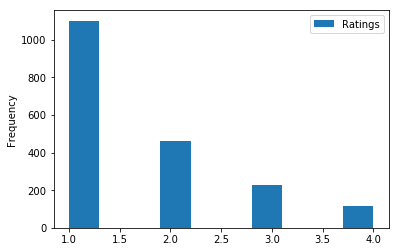

In [12]:
df_list = []
states = list(reviews_json.keys())
for state in states:
    use_state = []
    for review in reviews_json[state]:
        use_state.append(review['useful'])
    useful_hist = pd.DataFrame({'Ratings':use_state})
    df_list.append(useful_hist)

for i in range(0, len(df_list)):
    print(states[i] + " Rating Distribution")
    df_list[i].plot.hist(range=[1, 4])
    plt.show()

### Now let's try to build a simple linear support vector machine

Note, all support vector machine algorithm relies on drawing a separating hyperplane amongst the different classes. This is not necessarily guarenteed to exist. For a complete set of conditions that must be satisfied for this to be an appropriate algorithm to use, please see below:

http://www.unc.edu/~normanp/890part4.pdf

The following is also a good, and more general, introduction to Support Vector Machines:

http://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf

In [19]:
#First let's separate out our dataset into a training sample and a test sample
#We specify a training sample percentage of 80% of our total dataset. This is just a rule of thumb 
training_percent = 0.8
train_reviews = reviews[0:int(len(reviews)*training_percent)]
test_reviews = reviews[int(len(reviews)*training_percent):len(reviews)]
train_ratings = stars[0:int(len(stars)*training_percent)]
test_ratings = stars[int(len(stars)*training_percent):len(stars)]
train_useful = useful[0:int(len(useful)*training_percent)]
test_useful = useful[int(len(useful)*training_percent):len(useful)]

In order to use the machine learning algorithms in Sci-Kit learn, we first have to initialize a CountVectorizer object. We can use this object creates a matrix representation of each of our words. There are many options that we can specify when we initialize our CountVectorizer object (see documentation for full list) but they essentially all relate to how the words are represented in the final matrix.

In [20]:
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 200) 

train_data_features = vectorizer.fit_transform(train_reviews)
test_data_features = vectorizer.fit_transform(test_reviews)


In [21]:
vec = vectorizer
data = train_data_features.toarray()
print(data[1])
print(len(data[1]))
print(type(data))
len(data)

[0 0 0 2 0 0 0 0 0 4 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 2 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 1 0 1 0 0 0 0 2 0 1 3 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 2 1 0 0 0 1 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 1 7 0 0 0 0 4 1 1 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 2 0
 1 0 0 0 0 0 0 0 0 0 0 0 2 1 0]
200
<class 'numpy.ndarray'>


24004

In [22]:
vocab = vec.get_feature_names()
print(vocab)
len(vocab)

['about', 'after', 'again', 'all', 'also', 'always', 'am', 'amazing', 'an', 'and', 'any', 'are', 'area', 'around', 'as', 'asked', 'at', 'back', 'bad', 'bar', 'be', 'because', 'been', 'before', 'best', 'better', 'bit', 'both', 'bread', 'but', 'by', 'came', 'can', 'cheese', 'chicken', 'coffee', 'come', 'cooked', 'could', 'day', 'definitely', 'delicious', 'did', 'didn', 'dinner', 'do', 'don', 'down', 'drinks', 'eat', 'even', 'ever', 'everything', 'excellent', 'experience', 'few', 'first', 'flavor', 'food', 'for', 'fresh', 'friendly', 'fries', 'from', 'get', 'give', 'go', 'going', 'good', 'got', 'great', 'had', 'happy', 'has', 'have', 'he', 'her', 'here', 'hot', 'how', 'if', 'in', 'is', 'it', 'just', 'know', 'last', 'like', 'little', 'll', 'lobster', 'location', 'love', 'lunch', 'made', 'make', 'me', 'meal', 'menu', 'more', 'much', 'my', 'never', 'new', 'next', 'nice', 'night', 'no', 'not', 'now', 'of', 'off', 'on', 'one', 'only', 'or', 'order', 'ordered', 'other', 'our', 'out', 'over', 'p

200

In [28]:
train_data_features[0]

<1x200 sparse matrix of type '<class 'numpy.int64'>'
	with 57 stored elements in Compressed Sparse Row format>

Lets call a linear SVM instance from SK Learn have it train on our subset of reviews. We'll output the results to an output dataframe and then calculate a total accuracy percentage. 

In [29]:
lin_svm = svm.LinearSVC(multi_class='crammer_singer')

In [30]:
lin_svm = lin_svm.fit(train_data_features, train_useful)


In [ ]:
lin_svm_result = lin_svm.predict(test_data_features)

In [ ]:
output = pd.DataFrame( data={"Reviews": test_reviews, "useful": test_useful, "naive_lin": lin_svm_result} )
output['Accurate'] = np.where(output['Useful'] == output['naive_lin'], 1, 0)
accurate_percentage = float(sum(output['Accurate']))/float(len(output))

print(accurate_percentage)

In [50]:
#Let's do the same exercise as above but use TF-IDF, you can learn more about TF-IDF here:
#https://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html
tf_transformer = TfidfTransformer(use_idf=True)

train_data_features = tf_transformer.fit_transform(train_data_features)
test_data_features = tf_transformer.fit_transform(test_data_features)

lin_svm = lin_svm.fit(train_data_features, train_ratings)
lin_svm_result = lin_svm.predict(test_data_features)
output['lin_svm'] = lin_svm_result
output['Accurate'] = np.where(output['Rating'] == output['lin_svm'], 1, 0)
accurate_percentage = float(sum(output['Accurate']))/float(len(output))
print accurate_percentage

0.361546151283


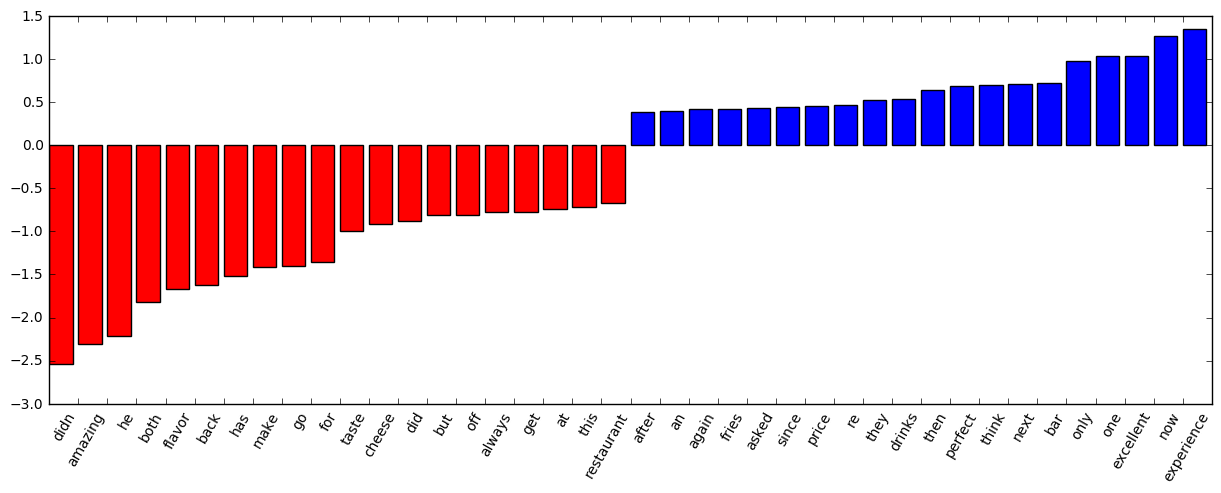

In [51]:
#Here we plot the features with the highest absolute value coefficient weight
plot_coefficients(lin_svm, vectorizer.get_feature_names())

SKLearn uses what's known as a pipeline. Instead of having to declare each of these objects on their own and passing them into each other, we can just create one object with all the necessary options specified and then use that to run the algorithm. For each pipeline below, we specify the vector to be the CountVectorizer object we have defined above, set it to use tfidf, and then specify the classifier that we want to use.

Below, we create a separate pipeline for Random Forest, a Bagged Decision Tree, and Multinomial Logistic Regression. We then append the results to the dataframe that we've already created.

In [68]:
# random_forest = Pipeline([('vect', vectorizer),
#                         ('tfidf', TfidfTransformer()), 
#                         ('clf', RandomForestClassifier())])
# random_forest.set_params(clf__n_estimators=100, clf__criterion='entropy').fit(train_reviews, train_ratings)
# output['random_forest'] = random_forest.predict(test_reviews)

# output['Accurate'] = np.where(output['Rating'] == output['random_forest'], 1, 0)
# accurate_percentage = float(sum(output['Accurate']))/float(len(output))
# print accurate_percentage

# bagged_dt = Pipeline([('vect', vectorizer),
#                         ('tfidf', TfidfTransformer()), 
#                         ('clf', BaggingClassifier())])
# bagged_dt.set_params(clf__n_estimators=100, clf__n_jobs=1).fit(train_reviews, train_ratings)
# output['bagged_dt'] = bagged_dt.predict(test_reviews)

# output['Accurate'] = np.where(output['Rating'] == output['bagged_dt'], 1, 0)
# accurate_percentage = float(sum(output['Accurate']))/float(len(output))
# print accurate_percentage

multi_logit = Pipeline([('vect', vectorizer),
                        ('tfidf', TfidfTransformer()), 
                        ('clf', MultinomialNB())])
multi_logit.set_params(clf__alpha=1, clf__fit_prior = True, clf__class_prior = None).fit(train_reviews, train_ratings)
output['multi_logit'] = multi_logit.predict(test_reviews)

output['Accurate'] = np.where(output['Rating'] == output['multi_logit'], 1, 0)
accurate_percentage = float(sum(output['Accurate']))/float(len(output))
print accurate_percentage


0.491502832389


#### Test results using all of the states

* 0.5383 from Naive TF-IDF Linear SVM
* 0.4567 from Naive TF-IDF Linear SVM using Harvard-IV dictionary
* 0.5241 from Naive TF-IDF Bagged DT using 100 estimators
* 0.496 from Naive TF-IDF Bagged DT using 100 estimators and Harvard-IV dictionary
* 0.5156 from Naive TF-IDF RandomForest and Harvard-IV dictionary
* 0.53 from Naive TF-IDF RF
* 0.458 from Naive TF-IDF SVM

As you can see, none of the above classifiers performs significantly better than a fair coin toss. This is most likely due to the heavily skewed distribution of review ratings. There are many reviews that receive 4 or 5 stars, therefore it is likely that the language associated with each review is being confused with each other. We can confirm this by looking at the "confusion matrix" of our predictions.

In [70]:
print metrics.confusion_matrix(test_ratings, bagged_dt.predict(test_reviews), labels = [1, 2, 3, 4, 5])

[[ 440   62   58  101   95]
 [ 137   74   96  141   79]
 [  81   58  170  368  143]
 [  70   36  105  751  560]
 [  75   25   47  582 1648]]


Each row and column corresponds to a rating number. For example, element (1,1) is the number of 1 star reviews that were correctly classified. Element (1,2) is the number of 1 star reviews that were incorrectly classified as 2 stars.  Therefore, the sum of the diagonal represents the total number of correctly classified reviews. As you can see, the bagged decision tree classifier is classifying many four starred reviews as five starred reviews and vice versa. 

This indicates that we can improve our results by using more aggregated categories. For example, we can call all four and five star reviews as "good" and all other review ratings as "bad".